# Attack on Diva using Decision Trees built with CFS and the noisy dataset 

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../../../"
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Diva data

loading the Diva RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.diva import load_diva_data, load_diva_randomforest # type: ignore

BB = load_diva_randomforest()
BB_DATA = load_diva_data('diva-blackbox-data2.npz')

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2094
           1       0.85      0.77      0.81       745

    accuracy                           0.90      2839
   macro avg       0.89      0.86      0.87      2839
weighted avg       0.90      0.90      0.90      2839



# Attack on the Decision Trees to create the attack models

In [4]:
noisy_dataset_x = pd.DataFrame(BB_DATA['X_validation_noisy'])
noisy_dataset_y = pd.DataFrame(BB_DATA['y_validation_noisy'])
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [5]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [6]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        f.write("Statistics on the noisy validation dataset\n")
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

Run the attack only if it hasn't already been run

In [7]:
TREES_BASE_FOLDER = Path("../experiment_output/")

In [8]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(BB_DATA['X_distance_separated']))]):
    
    for ind, path in enumerate([OUTPUT_FOLDER / f"{i}" for i in range(len(BB_DATA['X_distance_separated']))]):
        # create the output folder
        (OUTPUT_FOLDER / f"{ind}").mkdir(exist_ok=True)
        
        # load the local tree and label the noisy dataset
        local_tree = load_pickle_bz2(TREES_BASE_FOLDER/ f"{ind}" / "dt.bz2")
        
        compute_statistics_local_model(noisy_dataset_x, noisy_dataset_y, local_tree, BB, path, "statistics_noisy.txt")

        # use the "local" decision tree to label the statistical dataset
        x_attack = noisy_dataset_x.to_numpy()    
        y_attack = local_tree.predict(x_attack)
        path_shadow = str(path / "shadow")

        shadow_models = ShadowModelsManager(
            n_models=4,
            results_path=path_shadow,
            test_size=0.5,
            random_state=123,
            model_creator_fn=create_adaboost,
            categorical_mask=categorical_features_mask
        )
        
        shadow_models.fit(x_attack, y_attack)

        # extracting the dataset for the attack models
        attack_models_dataset = shadow_models.get_attack_dataset()

        # saving the attack dataset
        attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

        # Creating the attack model for each label using Adaboost
        path_attack = str(path / "attack")
        attack_models = AttackModelsManager(
                results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
        )
        
        attack_models.fit(attack_models_dataset)
else:
    print("The attack models already exist")

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specifi

By looking at the test reports of the attack models, it seems that they <span style="background: red">perform bad on both classes</span> with an accuracy of $\simeq .50$

# Creating the ensembles

In [9]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier, KClosestVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [11]:
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in range(len(BB_DATA['X_distance_separated']))]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in range(len(BB_DATA['X_distance_separated']))]

## Hard Voting

report full
              precision    recall  f1-score   support

          in       0.69      0.31      0.43      6575
         out       0.30      0.68      0.41      2807

    accuracy                           0.42      9382
   macro avg       0.50      0.49      0.42      9382
weighted avg       0.58      0.42      0.42      9382


Class 0
              precision    recall  f1-score   support

          in       0.63      0.08      0.14      4916
         out       0.30      0.89      0.45      2133

    accuracy                           0.33      7049
   macro avg       0.46      0.49      0.29      7049
weighted avg       0.53      0.33      0.23      7049


Class 1
              precision    recall  f1-score   support

          in       0.71      1.00      0.83      1659
         out       0.00      0.00      0.00       674

    accuracy                           0.71      2333
   macro avg       0.36      0.50      0.41      2333
weighted avg       0.51      0.71      0.59 

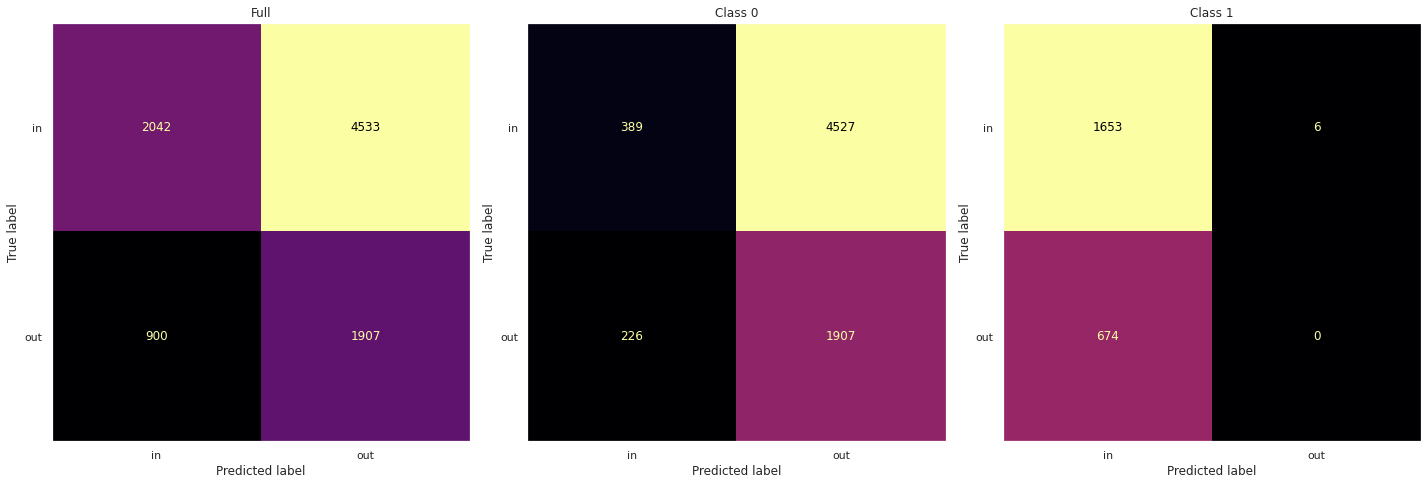

In [12]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)
evaluate_attack(hv0, hv1, BB, BB_DATA)

## Soft Voting

report full
              precision    recall  f1-score   support

          in       0.70      0.30      0.41      6624
         out       0.30      0.70      0.42      2839

    accuracy                           0.42      9463
   macro avg       0.50      0.50      0.42      9463
weighted avg       0.58      0.42      0.42      9463


Class 0
              precision    recall  f1-score   support

          in       0.63      0.06      0.11      4965
         out       0.30      0.92      0.45      2165

    accuracy                           0.32      7130
   macro avg       0.46      0.49      0.28      7130
weighted avg       0.53      0.32      0.22      7130


Class 1
              precision    recall  f1-score   support

          in       0.71      0.99      0.83      1659
         out       0.14      0.00      0.01       674

    accuracy                           0.71      2333
   macro avg       0.43      0.50      0.42      2333
weighted avg       0.55      0.71      0.59 

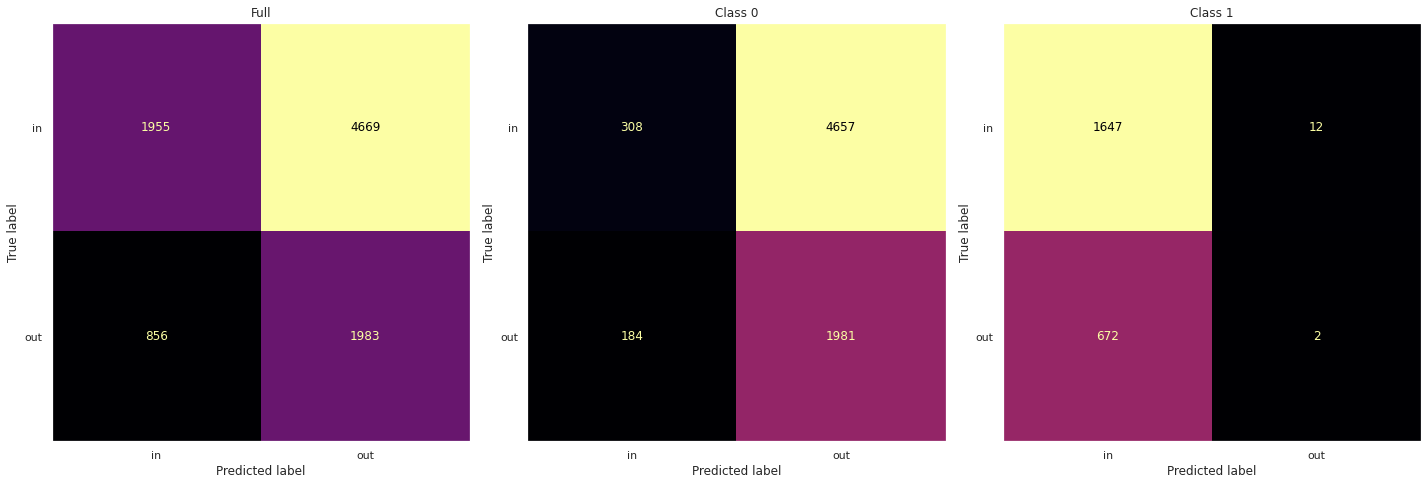

In [13]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)
evaluate_attack(sv0, sv1, BB, BB_DATA)